<a href="https://colab.research.google.com/github/Andiko-K/AQI-analysis-dicoding/blob/main/C1/C1W1_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# C1W1 Lab 2: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Downloading Dataset

In [ ]:
!wget -O /content/energy_efficiency.zip "https://github.com/Andiko-K/Tensorflow-Advanced-Techniques/raw/main/C1/dataset/energy_efficiency.zip"
!unzip ./energy_efficiency.zip -d ./dataset/

--2024-05-16 03:35:21--  https://github.com/Andiko-K/Tensorflow-Advanced-Techniques/raw/main/C1/dataset/energy_efficiency.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Andiko-K/Tensorflow-Advanced-Techniques/main/C1/dataset/energy_efficiency.zip [following]
--2024-05-16 03:35:22--  https://raw.githubusercontent.com/Andiko-K/Tensorflow-Advanced-Techniques/main/C1/dataset/energy_efficiency.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76321 (75K) [application/zip]
Saving to: ‘/content/energy_efficiency.zip’

/content/energy_eff 100%[===================>]  74.53K  --.-KB/s    in 0.009s 

## Imports

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Data Preparation

In [ ]:
df = pd.read_excel('./dataset/ENB2012_data.xlsx')
df = df.sample(frac = 1).reset_index(drop = True)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.64,784.0,343.0,220.5,3.5,5,0.25,5,16.92,20.29
1,0.64,784.0,343.0,220.5,3.5,3,0.25,3,16.93,20.03
2,0.76,661.5,416.5,122.5,7.0,4,0.40,2,40.57,40.47
3,0.69,735.0,294.0,220.5,3.5,3,0.10,1,11.13,14.61
4,0.64,784.0,343.0,220.5,3.5,4,0.40,4,19.00,22.25


In [ ]:
train, test = train_test_split(df, test_size = .2)
train_stats = train.describe()
train_stats.drop(columns=['Y1', 'Y2'], inplace=True)
train_stats = train_stats.transpose()

In [ ]:
train_Y1 = train.pop('Y1'); train_Y2 = train.pop('Y2')
train_Y = (np.array(train_Y1), np.array(train_Y2))

test_Y1 = test.pop('Y1'); test_Y2 = test.pop('Y2')
test_Y = (np.array(test_Y1), np.array(test_Y2))

In [ ]:
train_X = (train - train_stats['mean'])/train_stats['std']
test_X = (test - train_stats['mean'])/train_stats['std']

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [ ]:
input_layer = tf.keras.layers.Input(shape = (train.shape[-1],))
first = tf.keras.layers.Dense(128, activation = 'relu')(input_layer)
second = tf.keras.layers.Dense(128, activation = 'relu')(first)

#Y1 Output, fed directly from the second dense
y1_output = tf.keras.layers.Dense(1, name = 'Y1_output')(second)

#Y2 Output will come via third dense
third = tf.keras.layers.Dense(64, activation = 'relu')(second)
y2_output = tf.keras.layers.Dense(1, name = 'Y2_output')(third)

#Define the model
model = tf.keras.Model(inputs = input_layer,
                       outputs = [y1_output, y2_output])

### Drawing Model Architecture

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  1152      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 64)                   8256      ['dense_1[0][0]']             
                                                                                              

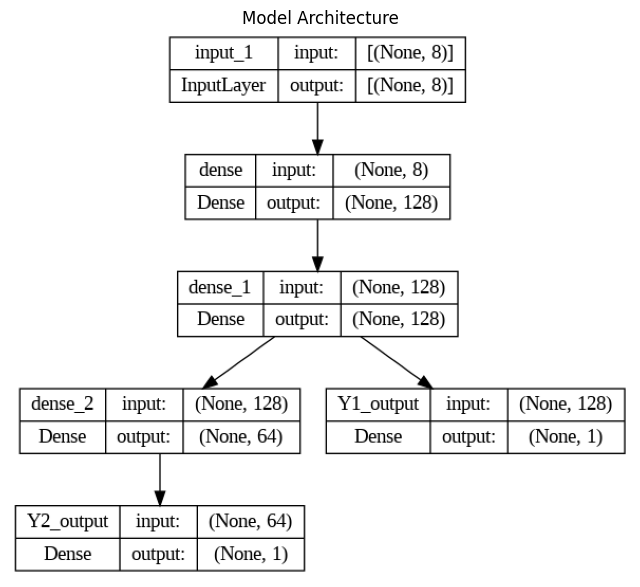

In [ ]:
file_name = "./model_architecture.png"

tf.keras.utils.plot_model(model, to_file = file_name,
                          show_shapes = True, show_layer_names = True)
plt.figure(figsize = (8,8))
img = plt.imread(file_name)
plt.imshow(img)
plt.title('Model Architecture')
plt.axis('off')
plt.savefig(file_name)
plt.show()

## Configuring Parameters

In [ ]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'Y1_output': 'mse', 'Y2_output': 'mse'},
              metrics={'Y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'Y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Training the Model

In [ ]:
# Train the model for 500 epochs
history = model.fit(train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 6s 26ms/step - loss: 241.6731 - Y1_output_loss: 114.1650 - Y2_output_loss: 127.5082 - Y1_output_root_mean_squared_error: 10.6848 - Y2_output_root_mean_squared_error: 11.2920 - val_loss: 57.0166 - val_Y1_output_loss: 19.4185 - val_Y2_output_loss: 37.5981 - val_Y1_output_root_mean_squared_error: 4.4066 - val_Y2_output_root_mean_squared_error: 6.1317
Epoch 2/500
62/62 [==============================] - 1s 13ms/step - loss: 36.7991 - Y1_output_loss: 13.8379 - Y2_output_loss: 22.9612 - Y1_output_root_mean_squared_error: 3.7199 - Y2_output_root_mean_squared_error: 4.7918 - val_loss: 65.8041 - val_Y1_output_loss: 13.5594 - val_Y2_output_loss: 52.2447 - val_Y1_output_root_mean_squared_error: 3.6823 - val_Y2_output_root_mean_squared_error: 7.2280
Epoch 3/500
62/62 [==============================] - 0s 8ms/step - loss: 24.3925 - Y1_output_loss: 9.8369 - Y2_output_loss: 14.5555 - Y1_output_root_mean_squared_error: 3.1364 - Y2_output_root_mean_s

## Evaluate Model and Plot Metrics

In [ ]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=test_X, y=test_Y)
print("Loss = {:.2f}\nY1_loss = {:.2f}\nY1_mse = {:.2f}\nY2_loss = {:.2f}\nY2_mse = {:.2f}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 1.3419 - Y1_output_loss: 0.3821 - Y2_output_loss: 0.9598 - Y1_output_root_mean_squared_error: 0.6181 - Y2_output_root_mean_squared_error: 0.9797
Loss = 1.34
Y1_loss = 0.38
Y1_mse = 0.62
Y2_loss = 0.96
Y2_mse = 0.98


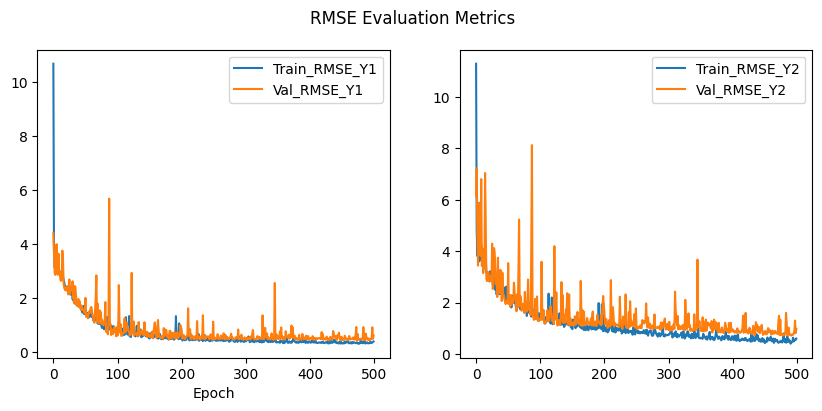

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].plot(history.history['Y1_output_root_mean_squared_error'], label = 'Train_RMSE_Y1')
ax[0].plot(history.history['val_Y1_output_root_mean_squared_error'], label = 'Val_RMSE_Y1')
ax[0].legend(); ax[0].set_xlabel('Epoch')

ax[1].plot(history.history['Y2_output_root_mean_squared_error'], label = 'Train_RMSE_Y2')
ax[1].plot(history.history['val_Y2_output_root_mean_squared_error'], label = 'Val_RMSE_Y2')
ax[1].legend(); ax[0].set_xlabel('Epoch')

fig.suptitle('RMSE Evaluation Metrics')


plt.show()

5/5 [==============================] - 0s 4ms/step


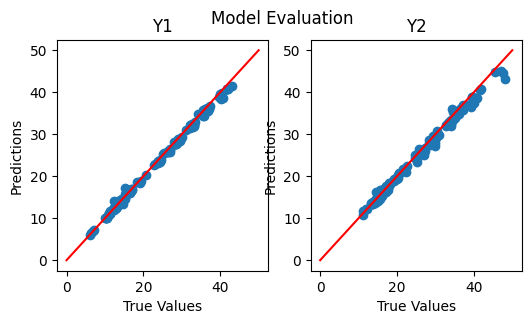

In [ ]:
Y_pred = model.predict(test_X)

fig, ax = plt.subplots(1,2, figsize = (6,3))
ax[0].scatter(test_Y[0], Y_pred[0]); ax[0].set_title('Y1')
ax[1].scatter(test_Y[1], Y_pred[1]); ax[1].set_title('Y2')

fig.suptitle('Model Evaluation')
for axes in ax:
  axes.set_xlabel('True Values')
  axes.set_ylabel('Predictions')
  axes.plot([0,50],[0,50], c = 'red')
plt.show()